# *SIR* model exploration

In [316]:
from scipy.integrate import odeint, solve_bvp, solve_ivp, quad
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
import matplotlib
import copy

The SIR model is given by

\begin{equation} \begin{split} S'&= -kSI\\ I'&= kSI-qI\\R'&= qI
\end{split}\end{equation}
subject to $S+I+R=1$,
where $S$ represents the proportion of the total population that is susceptible to the disease, $I$ represents the proportion of the total population that is infected, and $R$ represents the proportion of the total population that is recovered from the disease.

In [326]:
def ode_fun(u, t, k, q):
    out = np.zeros(3)

    S = u[0]
    I = u[1]
    R = u[2]

    out[0] = -k*S*I
    out[1] = k*S*I-q*I
    out[2] = q*I

    return out

First, generate an example observation data with given $k$, $q$, and $u_0$ values and randomly sampling data.

In [327]:
''' We numerically solve for the solution of the SIR model for the stated values
of k, q, and u0. '''

k_true = 1 # Do not change
q_true = 0.3 # Do not change
u0_true = [0.9,0.1,0] # Do not change

t = np.linspace(0, 20, 1201) # domain on which to plot the solution
sol = odeint(ode_fun, u0_true, t, args=(k_true,q_true)) # numerical solution

In [328]:
# get the observation data
# I chose a random seed for data generation to have fixed data points
np.random.seed(26)
mu, sigma = 0, 0.05 # mean and standard deviation

u0_data = u0_true.copy()
for j in range(0,3):
  u0_data[j] = u0_data[j]+ np.random.normal(mu,1e-3,1)[0]

t_data = []
delt = t[1]-t[0]
R_data = []
I_data = []
for j in range(int(np.round(len(sol)/4))):

    s = np.random.normal(mu, sigma, 1)

    if s>0:
        t_data.append(delt*j)

        s1 = np.random.normal(mu, sigma, 1)[0]
        s2 = np.random.normal(mu, sigma, 1)[0]

        I_data.append(sol[j,1]+s1)
        R_data.append(sol[j,2]+s2)


### Nelder-Mead algorithm

In [329]:
def f(U,t_data,I_data,R_data,u0):

    # This function is for use with the Nelder-Mead algorithm.

    k = U[0]
    q = U[1]

    sol = odeint(ode_fun, u0, t_data, args=(k,q))

    diff = np.zeros((2,len(t_data)))
    diff[0,:] = sol[:,1]-I_data
    diff[1,:] = sol[:,2]-R_data

    return np.linalg.norm(diff)

In [330]:
# Numerically solve for q and k using the Nelder-Mead algorithm

x0  = [1,0.5]

res = minimize(f, x0, method='Nelder-Mead', tol=1e-6,args = (t_data,I_data,R_data,u0_data))


In [331]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.8738685329775862
             x: [ 9.907e-01  2.991e-01]
           nit: 48
          nfev: 92
 final_simplex: (array([[ 9.907e-01,  2.991e-01],
                       [ 9.907e-01,  2.991e-01],
                       [ 9.907e-01,  2.991e-01]]), array([ 8.739e-01,  8.739e-01,  8.739e-01]))

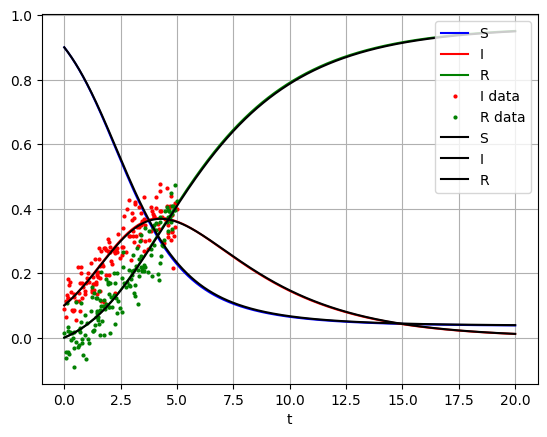

In [332]:
%matplotlib inline

#matplotlib.use('nbagg')

k = res['x'][0]
q = res['x'][1]

sol2 = odeint(ode_fun, u0_true, t, args=(k,q))

plt.plot(t, sol[:, 0], 'b', label='S')
plt.plot(t, sol[:, 1], 'r', label='I')
plt.plot(t, sol[:, 2], 'g', label='R')
plt.plot(t_data,I_data,'ro', label='I data',ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t, sol2[:, 0], '-k', label='S')
plt.plot(t, sol2[:, 1], '-k', label='I')
plt.plot(t, sol2[:, 2], '-k', label='R')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.grid()
plt.show()

In [281]:
k, q

(0.9907360419713542, 0.29913723129363606)

## Data Interpolation

I used two different methods for data interpolation. The first is by fitting a degree 3 polynomial. This has the advantage of fitting well within the scope of the given data points but the behavior of the function near the boundaries will differ greatly from the actual function. Another interpolation method I used is fitting a known curve that would more closely match the solution. For this method, I used the following functions as the base for my observation functions:

\begin{equation} \begin{split} 
I^{obs} &= ce^{-a(t-b)^2}\\ 
R^{obs} &= \frac{1}{1 + e^{-a(t-b)}}
\end{split}\end{equation}

and used scipy.optimize.curve_fit to fit the parameters using the given data.

In [283]:
I_poly = np.poly1d(np.polyfit(t_data, I_data, 3))
R_poly = np.poly1d(np.polyfit(t_data, R_data, 3))

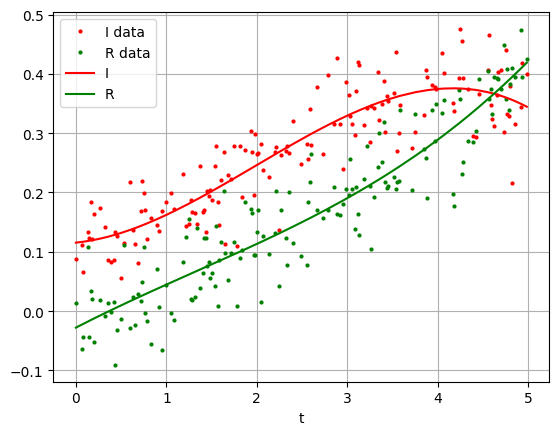

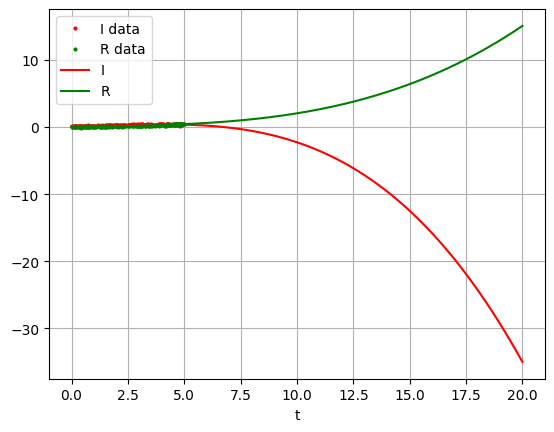

In [337]:
plt.plot(t_data,I_data,'ro', label='I data', ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)

plt.plot(t_data, I_poly(t_data), 'r', label="I")
plt.plot(t_data, R_poly(t_data), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()

plt.plot(t_data,I_data,'ro', label='I data', ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)

plt.plot(t, I_poly(t), 'r', label="I")
plt.plot(t, R_poly(t), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()


In [285]:
from scipy.optimize import curve_fit

In [286]:
def Io_func(t, a, b, c):
    return c*np.exp(-a * (t - b)**2)

def Ro_func(t, a, b):
    return 1 / (1 + np.exp(-a * (t - b)))


In [287]:
I_popt, _ = curve_fit(Io_func, t_data, I_data, bounds=([0, 0, 0], [1, 20, 1]))
R_popt, _ = curve_fit(Ro_func, t_data, R_data, bounds=([0, 0], [1, 20]))

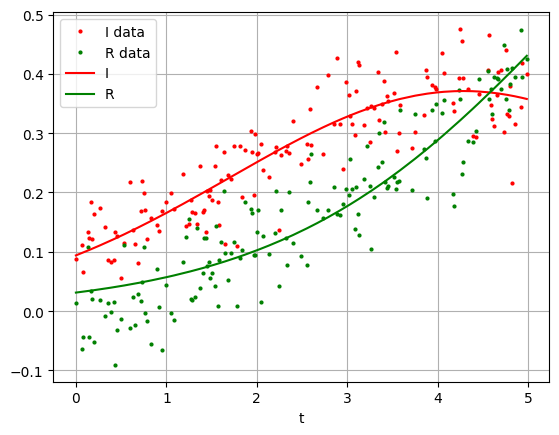

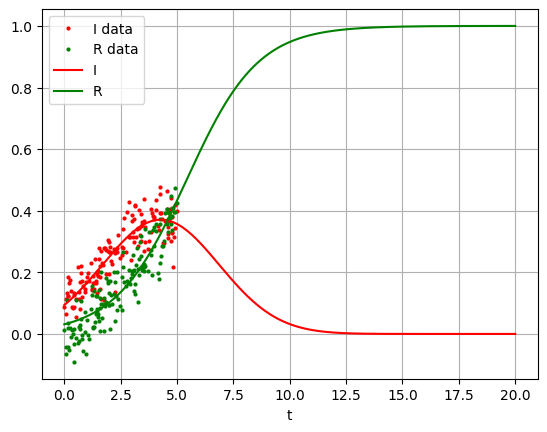

In [342]:
plt.plot(t_data,I_data,'ro', label='I data', ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t_data, Io_func(t_data, *I_popt), 'r', label="I")
plt.plot(t_data, Ro_func(t_data, *R_popt), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()

plt.plot(t_data,I_data,'ro', label='I data', ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t, Io_func(t, *I_popt), 'r', label="I")
plt.plot(t, Ro_func(t, *R_popt), 'g', label="R")
plt.legend(loc='upper left')
plt.xlabel('t')
plt.grid()
plt.show()

In the end, I decided to use the curve fit method as my observation functions.

In [289]:
Io = lambda t: Io_func(t, *I_popt)
Ro = lambda t: Ro_func(t, *R_popt)

#Io = I_poly
#Ro = R_poly

## Single Gradient

The cost functional is given by 

$J = \frac{1}{2} \int_0^5 (I - I^{obs})^2 + (R - R^{obs})^2 dt$

(I modified it slightly by including 1/2 so the constants would cancel when solving for the gradient)

The gradient of each $k, q, S_0, I_0, R_0$ can be found by solving for the adjoint equation. The gradients are given by:

\begin{equation}
\begin{split}
\nabla_{S_0} J &= -P_S(0) \\
\nabla_{I_0} J &= -P_I(0) \\
\nabla_{R_0} J &= -P_R(0) \\
\nabla_{k} J &= SI(P_S - P_I) \\
\nabla_{q} J &= I(P_I - P_R)
\end{split}
\end{equation}

Using these individual values, we can find the gradient of the cost functional and update the initial parameters by taking a step into the direction of the gradient.

def ode_fun(t, u, k, q):
    out = np.zeros(3)

    S = u[0]
    I = u[1]
    R = u[2]

    out[0] = -k*S*I
    out[1] = k*S*I-q*I
    out[2] = q*I

    return out

# Initial guess
k0 = 1.1
q0 = 0.25
I0 = 0.1
R0 = 0.02
S0 = 1 - I0 - R0

params = [k0, q0, S0, I0, R0]
u0 = params[2:]
SIR_sol = solve_ivp(ode_fun, [0, 20], u0, args=(k,q), dense_output=True)

### Adjoint equation

In [293]:
def ode_adjoint(t, P):
    S = SIR_sol.sol(t)[0]
    I = SIR_sol.sol(t)[1]
    R = SIR_sol.sol(t)[2]
    
    P_S = k*I*(P[0] - P[1])
    P_I = I - Io(t) + k*S*(P[0] - P[1]) + q*(P[1] - P[2])
    P_R = R - Ro(t)

    return np.vstack([P_S, P_I, P_R])

def adjoint_bc(Pa, Pb):
    return np.array([Pb[0], Pb[1], Pb[2]])

t_mesh = np.linspace(0, 20, 101)
p0 = np.ones((3, t_mesh.size))
p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, p0)

### Gradient Calculation

In [294]:
DJ_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
DJ_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

DJ_k = quad(DJ_k_func, 0, 5)[0]
DJ_q = quad(DJ_q_func, 0, 5)[0]
DJ_S0 = -p.sol(0)[0]
DJ_I0 = -p.sol(0)[1]
DJ_R0 = -p.sol(0)[2]

DJ_k, DJ_q, DJ_S0, DJ_I0, DJ_R0

(-0.5101449124879053,
 0.3347948080151843,
 -1.5938936343742443,
 -3.0067847137451182,
 -1.5098476466575588)

In [295]:
np.set_printoptions(precision=6, suppress=True)

In [296]:
grad = np.array([DJ_k, DJ_q, 0, DJ_I0 - DJ_S0, DJ_R0 - DJ_S0])
grad[2] = -grad[3]-grad[4]
lr = 0.001
step = lr * grad
params - step

array([1.10051 , 0.249665, 0.878671, 0.101413, 0.019916])

## Gradient Descent

Below shows the iterated gradient descent algorithm to solve for the option $k, q, S_0, I_0, R_0$ given the data points and the observation functions.

In [ ]:
k0 = 1.1
q0 = 0.25
I0 = 0.03
R0 = 0.02
S0 = 1 - I0 - R0

params = [k0, q0, S0, I0, R0]

n_iter = 2000
lr = 0.001

cost_hist = []
param_hist = []

for i in range(n_iter):
    print("Step {}".format(i))
    print("Params: {}".format(params))

    k = params[0]
    q = params[1]
    u0 = params[2:]
    SIR_sol = solve_ivp(ode_fun, [0, 20], u0, args=(k,q), dense_output=True)

    cost_func = lambda t: (SIR_sol.sol(t)[1] - Io(t))**2 + (SIR_sol.sol(t)[2] - Ro(t))**2
    J = 0.5 * quad(cost_func, 0, 5)[0]
    print("Cost: {:.6}".format(J))
    cost_hist.append(J)

    t_mesh = np.linspace(0, 20, 101)
    p0 = np.ones((3, t_mesh.size))
    p = solve_bvp(ode_adjoint, adjoint_bc, t_mesh, p0)

    DJ_k_func = lambda t: SIR_sol.sol(t)[0] * SIR_sol.sol(t)[1] * (p.sol(t)[0] - p.sol(t)[1])
    DJ_q_func = lambda t: SIR_sol.sol(t)[1] * (p.sol(t)[1] - p.sol(t)[2])

    DJ_k = quad(DJ_k_func, 0, 5)[0]
    DJ_q = quad(DJ_q_func, 0, 5)[0]
    DJ_S0 = -p.sol(0)[0]
    DJ_I0 = -p.sol(0)[1]
    DJ_R0 = -p.sol(0)[2]

    grad = np.array([DJ_k, DJ_q, 0, DJ_I0 - DJ_S0, DJ_R0 - DJ_S0])
    grad[2] = -grad[3]-grad[4]
    step = lr * grad
    params -= step
    param_hist.append(copy.deepcopy(params))

    print()


    

Step 0 <br>
Params: [1.1, 0.25, 0.95, 0.03, 0.02]<br>
Cost: 0.0363634<br>


Step 1<br>
Params: [1.101096 0.249939 0.938824 0.040712 0.020464]<br>
Cost: 0.0190195<br>


Step 2<br>
Params: [1.101954 0.250127 0.931789 0.047313 0.020898]<br>
Cost: 0.0126395<br>


Step 3<br>
Params: [1.1027   0.250413 0.92628  0.052407 0.021312]<br>
Cost: 0.009232<br>


Step 4<br>
Params: [1.10337  0.250755 0.921658 0.056632 0.02171 ]<br>
Cost: 0.00719068<br>


Step 5<br>
Params: [1.103984 0.251133 0.917637 0.060269 0.022094]<br>
Cost: 0.00590636<br>


Step 6<br>
...<br>
Step 1999<br>
Params: [1.235661 0.316886 0.902678 0.089018 0.008304]<br>
Cost: 0.011618

In [318]:
param_hist = np.array(param_hist)

Interestingly, the cost drops dramatically in the first few iterations then goes back up dramatically, after which it slowly decreases.

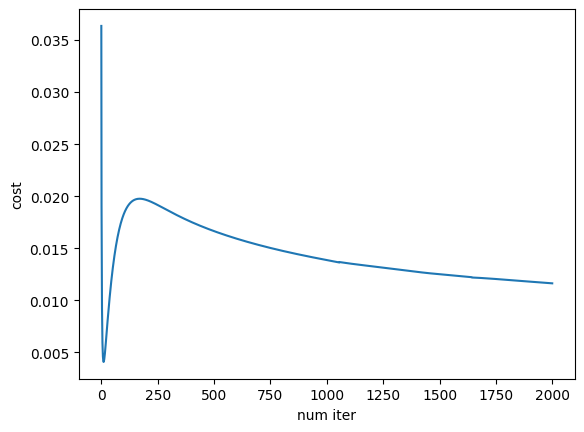

In [339]:
plt.plot(cost_hist)
plt.xlabel("num iter")
plt.ylabel("cost")
plt.show()

## Plot comparing true SIR and fitted SIR

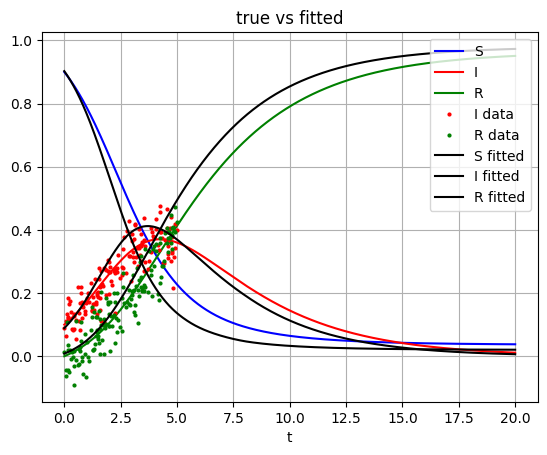

In [349]:
plt.plot(t, sol[:, 0], 'b', label='S')
plt.plot(t, sol[:, 1], 'r', label='I')
plt.plot(t, sol[:, 2], 'g', label='R')
plt.plot(t_data,I_data,'ro', label='I data',ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t, SIR_sol.sol(t)[0], '-k', label='S fitted')
plt.plot(t, SIR_sol.sol(t)[1], '-k', label='I fitted')
plt.plot(t, SIR_sol.sol(t)[2], '-k', label='R fitted')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title("true vs fitted")
plt.grid()
plt.show()

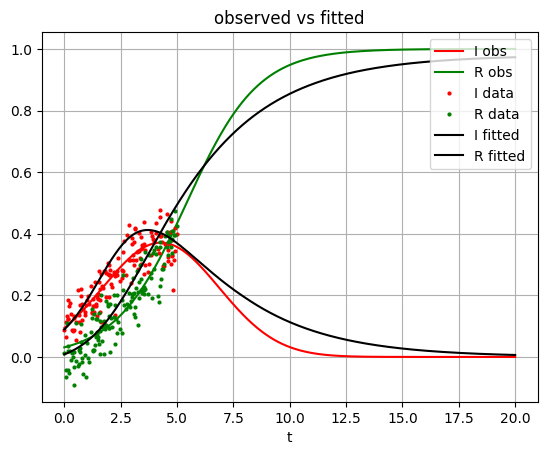

In [350]:
plt.plot(t, Io(t), 'r', label='I obs')
plt.plot(t, Ro(t), 'g', label='R obs')
plt.plot(t_data,I_data,'ro', label='I data',ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t, SIR_sol.sol(t)[1], '-k', label='I fitted')
plt.plot(t, SIR_sol.sol(t)[2], '-k', label='R fitted')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title("observed vs fitted")
plt.grid()
plt.show()

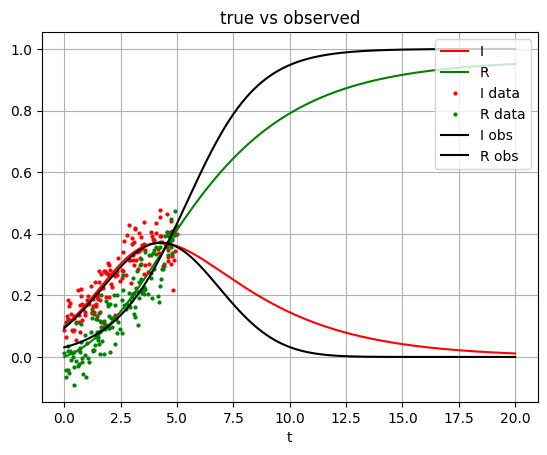

In [351]:
plt.plot(t, sol[:, 1], 'r', label='I')
plt.plot(t, sol[:, 2], 'g', label='R')
plt.plot(t_data,I_data,'ro', label='I data',ms = 2)
plt.plot(t_data,R_data,'go', label='R data', ms = 2)
plt.plot(t, Io(t), '-k', label='I obs')
plt.plot(t, Ro(t), '-k', label='R obs')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title("true vs observed")
plt.grid()
plt.show()

In [340]:
params

array([1.235708, 0.316894, 0.902691, 0.089006, 0.008303])

## Conclusion

Although the plots don't align perfectly, we can see that it does look pretty close. From the final paramter values, $q, S_0, I_0, R_0$ converged pretty close to the desired values, whereas $k$ remained a bit off. It is important to note that these outputs are heavily dependent on the random data points generated and the interpolated observation function. It is quite clear however that it did not perform nearly as well as the Nelder-Mead algorithm, which was pretty exact to the true values (although we didn't account for the different initial conditions for that algorithm). All in all, I felt that my gradient descent algorithm did a decent job finding the true initial and parameter values.